In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack, vstack
import datetime
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv('features.csv')
test = pd.read_csv('features_test.csv')
train.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
0,0,1430198770,7,11,5,2098,1489,20,0,0,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1,1430220345,0,42,4,1188,1033,9,0,1,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,2,1430227081,7,33,4,1319,1270,22,0,0,...,4,3,1,13.0,2130,0,0,1830,0,63
3,3,1430263531,1,29,4,1779,1056,14,0,0,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,4,1430282290,7,13,4,1431,1090,8,1,0,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
test.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
0,6,1430287923,0,93,4,1103,1089,8,0,1,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
1,7,1430293357,1,20,2,556,570,1,0,0,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
2,10,1430301774,1,112,2,751,808,1,0,0,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
3,13,1430323933,1,27,3,708,903,1,1,1,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
4,16,1430331112,1,39,4,1259,661,4,0,0,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [4]:
train.shape, test.shape

((97230, 109), (17177, 103))

**Подход 1: градиентный бустинг "в лоб"**

Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. В данном разделе предлагается попробовать градиентный бустинг для решения нашей задачи.

В отчете по данному этапу должны содержаться ответы на следующие вопросы:

**1. Какие признаки имеют пропуски среди своих значений (приведите полный список имен этих признаков)? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?**

In [5]:
res = pd.Series()
for col in train.columns:
    val = train[col].notnull().value_counts()
    if len(val) > 1:
        res[col] = len(train) - val[1]
        
new_res = pd.DataFrame({'Non_count': res.sort_values(ascending=False)})
new_res['Non_%'] = round(res / len(train) * 100)

In [56]:
new_res

,Non_count,Non_%
first_blood_player2,43987,45.0
radiant_flying_courier_time,27479,28.0
dire_flying_courier_time,26098,27.0
first_blood_player1,19553,20.0
first_blood_team,19553,20.0
first_blood_time,19553,20.0
dire_bottle_time,16143,17.0
radiant_bottle_time,15691,16.0
radiant_first_ward_time,1836,2.0
dire_first_ward_time,1826,2.0


first_blood_player2 - второй игрок не был причастен к первому убийству.  
first_blood_time - в 20% случаев первой крови нет в первые 5 минут игры.

**2. Как называется столбец, содержащий целевую переменную?**

In [7]:
set(train.columns) - set(test.columns)

{'barracks_status_dire',
 'barracks_status_radiant',
 'duration',
 'radiant_win',
 'tower_status_dire',
 'tower_status_radiant'}

In [8]:
train = train.fillna(0)
test = test.fillna(0)

y_train = train["radiant_win"]

X_train = train.drop([
    'barracks_status_dire',
    'barracks_status_radiant',
    'duration',
    'radiant_win',
    'tower_status_dire',
    'tower_status_radiant'
], axis=1);

radiant_win

**3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти выше по тексту. Какое качество при этом получилось?**

In [9]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
def gb_cross(X, y):
    scores = {}

    for n_estimators in [10, 20, 30, 50]:
        print('n_estimators = ', n_estimators)
        model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print('Score : %.4f' % score)
        print(f'Time elapsed: {datetime.datetime.now() - start_time}')

        scores[n_estimators] = score
        print()
        
    return pd.Series(scores)

In [11]:
scores = gb_cross(X_train, y_train)

n_estimators =  10
Score : 0.6649
Time elapsed: 0:00:22.703298

n_estimators =  20
Score : 0.6825
Time elapsed: 0:00:29.095664

n_estimators =  30
Score : 0.6900
Time elapsed: 0:00:40.857337

n_estimators =  50
Score : 0.6975
Time elapsed: 0:01:12.319137



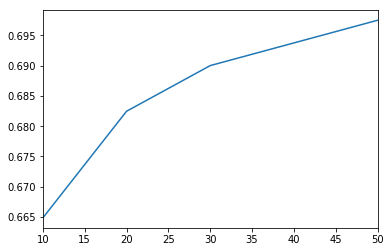

In [12]:
scores.plot()
plt.show()

**4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что можно сделать, чтобы ускорить его обучение при увеличении количества деревьев?**

Имеет смысл использовать больше 30 деревьев. Для ускорения обучения можно снизить глубину дерева, использовать только часть выборки, применить SGD.

**Подход 2: логистическая регрессия**

Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорение анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия. В данном разделе предлгается применить ее к данным, а также попробовать различные манипуляции с признаками.

В отчете по данному этапу должны содержаться ответы на следующие вопросы:

**1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем можно объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?**

In [13]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)

In [14]:
def lr_cross(X, y):
    scores = {}

    for c in [0.001, 0.01, 0.1, 1]:

        print('C = ', c)
        model = LogisticRegression(C=c, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print('Score: %.4f' % score)
        print(f'Time elapsed: {datetime.datetime.now() - start_time}')

        scores[c] = score
        print()

    return pd.Series(scores)

In [15]:
scores = lr_cross(X_train, y_train)

C =  0.001
Score: 0.7165
Time elapsed: 0:00:07.747443

C =  0.01
Score: 0.7166
Time elapsed: 0:00:09.698555

C =  0.1
Score: 0.7166
Time elapsed: 0:00:09.981571

C =  1
Score: 0.7166
Time elapsed: 0:00:09.486542



Наилучшее значение показателя AUC-ROC достигается уже при C = 0.01 и равно 0.72.
В сравнении с градиентным бустингом, логистическая регрессия работает заметно быстрее и качество выше (если рассматривать 50 деревьев). Отсутствие разницы может говорить о линейной связи между признаками.

**2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем можно объяснить это изменение?**

In [16]:
hero_r = [f'r{i}_hero' for i in range (1, 6)]
hero_d = [f'd{i}_hero' for i in range (1, 6)]
columns = ['lobby_type'] + hero_r + hero_d
X_train.drop(columns, axis=1, inplace=True)
X_test.drop(columns, axis=1, inplace=True)

In [17]:
X_train.shape, X_test.shape

((97230, 92), (17177, 92))

In [18]:
lr_cross(X_train, y_train)

C =  0.001
Score: 0.7165
Time elapsed: 0:00:06.656381

C =  0.01
Score: 0.7167
Time elapsed: 0:00:08.949512

C =  0.1
Score: 0.7166
Time elapsed: 0:00:08.020459

C =  1
Score: 0.7166
Time elapsed: 0:00:07.955455



0.001    0.716469
0.010    0.716657
0.100    0.716636
1.000    0.716633
dtype: float64

Качество не изменилось. Это может быть связано с тем, что мы задали случайный порядок категориальным признакам

**3. Сколько различных идентификаторов героев существует в данной игре?**

In [19]:
heros = set(train[hero_r + hero_d].values.ravel())
n = len(heros)
max_id = max(heros)
print('Уникальных героев: ', n)
print('Максимальный ID', max_id)

Уникальных героев:  108
Максимальный ID 112


**4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем можно это объяснить?**

In [20]:
def get_pick(train, max_id):
    X_pick = np.zeros((train.shape[0], max_id))

    for i, match_id in enumerate(train.index):
        for p in range(5):
            X_pick[i, train.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, train.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
    return X_pick

X_train_pick = get_pick(train, max_id)
X_test_pick = get_pick(test, max_id)
X_train_pick.shape, X_test_pick.shape

((97230, 112), (17177, 112))

In [21]:
type(X_train_pick), type(X_train)

(numpy.ndarray, pandas.core.frame.DataFrame)

In [22]:
X_train_bag_of_heros = np.concatenate([X_train.values, X_train_pick], axis=1)
X_test_bag_of_heros = np.concatenate([X_test.values, X_test_pick], axis=1)
X_train_bag_of_heros.shape

(97230, 204)

In [24]:
scores = lr_cross(X_train_bag_of_heros, y_train)

C =  0.001
Score: 0.7464
Time elapsed: 0:00:09.020516

C =  0.01
Score: 0.7518
Time elapsed: 0:00:14.173811

C =  0.1
Score: 0.7520
Time elapsed: 0:00:18.815076

C =  1
Score: 0.7520
Time elapsed: 0:00:20.184155



Качество значительно улучшилось. Это говорит о том, что информация о героях сильно влияет на прогноз.

**5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?**

In [25]:
log_reg = LogisticRegression(C=0.1, random_state=42)
log_reg.fit(X_train_bag_of_heros, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
pred = pd.Series(log_reg.predict_proba(X_test_bag_of_heros)[:, 1])
pred.describe()

count    17177.000000
mean         0.517098
std          0.221000
min          0.008321
25%          0.345743
50%          0.522844
75%          0.691823
max          0.996488
dtype: float64

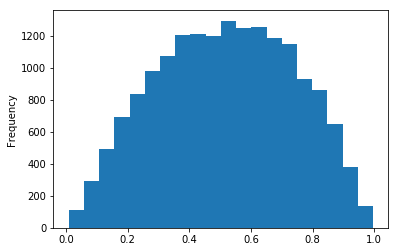

In [27]:
pred.plot.hist(bins=20)

In [28]:
submission = pd.read_csv('submission.csv')
submission['radiant_win'] = pred
submission.to_csv('new_sub.csv', index=None)

**Бонус - потестируем другие модели**

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 42, n_estimators = 20)

score = cross_val_score(rf_model, X_train_bag_of_heros, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
print('Score: %.4f' % score)

Score: 0.6567


In [57]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(random_state=17, learning_rate=0.1, max_depth=3, verbose=False)

score = cross_val_score(cat_model, X_train_bag_of_heros, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
print('Score: %.4f' % score)

Score: 0.7463


In [32]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(3, 0.01, 30, objective='binary:logistic', random_state=42, booster='gblinear', scale_pos_weight=109)

score = cross_val_score(xgb_model, X_train_bag_of_heros, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
print('Score: %.4f' % score)

Score: 0.7089


In [31]:
from lightgbm import LGBMClassifier

light_model = LGBMClassifier(n_estimators=200)

score = cross_val_score(light_model, X_train_bag_of_heros, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
print('Score: %.4f' % score)

Score: 0.7387


In [36]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.5], # 0.005
    'n_estimators': [400], # 40, 1000
    'num_leaves': [5], # 10, 15
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.66],
    'subsample' : [0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.4],
    }

# Create classifier to use
mdl = LGBMClassifier(boosting_type= 'gbdt',
          objective = 'roc_auc',
          n_jobs = 3, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [37]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(mdl, gridParams,
                    verbose=3,
                    cv=cv,
                    n_jobs=-1)

grid.fit(X_train_bag_of_heros, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=3, num_leaves=31,
        objective='roc_auc', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.5], 'n_estimators': [400], 'num_leaves': [5], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'random_state': [501], 'colsample_bytree': [0.66], 'subsample': [0.75], 'reg_alpha': [1, 1.2], 'reg_lambda': [1, 1.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [38]:
grid.best_params_, grid.best_score_

({'boosting_type': 'gbdt',
  'colsample_bytree': 0.66,
  'learning_rate': 0.5,
  'n_estimators': 400,
  'num_leaves': 5,
  'objective': 'binary',
  'random_state': 501,
  'reg_alpha': 1.2,
  'reg_lambda': 1.4,
  'subsample': 0.75},
 0.667612876684151)

**Лучшего качества в лоб добиться не вышло)**